### Pegando pontos de interesse da mascara

In [1]:
import numpy as np
import os
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.patches as patches
import random

### Visualização dos Patches

In [2]:
def visualize_patch_centers(image, centers, patch_size):
    fig, ax = plt.subplots(1)
    
    image_np = np.array(image)
    
    if image_np.max() > 1:
        image_np = image_np / 255.0
    
    ax.imshow(image_np)
    
    patch_height, patch_width = patch_size
    
    for (h, w) in centers:
        rect = patches.Rectangle(
            (w - patch_width // 2, h - patch_height // 2), 
            patch_width, patch_height,
            linewidth=1, edgecolor='red', facecolor='none'
        )
        ax.add_patch(rect)
        plt.plot(w, h, marker='v', color='r')
    
    ax.set_xlim([0, image_np.shape[1]])
    ax.set_ylim([image_np.shape[0], 0])
    
    plt.show()

In [3]:
def listar_imagens(diretorio_raiz, extensoes_imagens=None):
    if extensoes_imagens is None:
        extensoes_imagens = ['.jpg', '.jpeg', '.png']

    arquivos_imagens = []
    for dirpath, _, filenames in os.walk(diretorio_raiz):
        for filename in filenames:
            if any(filename.lower().endswith(extensao) for extensao in extensoes_imagens):
                caminho_completo = os.path.join(dirpath, filename)
                arquivos_imagens.append(caminho_completo)
    return arquivos_imagens
  
def exibir_imagens(lista_de_caminhos, largura=40, altura=25, path=True):
    num_imagens = len(lista_de_caminhos)
    
    if path:
    
      fig, axes = plt.subplots(1, num_imagens, figsize=(largura, altura))
    
      for i, caminho in enumerate(lista_de_caminhos):

          imagem = Image.open(caminho)
            
          axes[i].imshow(imagem)
          axes[i].axis('off')
          img = caminho.split("/")
          img = img[len(img)-1].replace("\\", " ").replace(".png", "")
          if "for" in img:
            img = img.replace("for intraepithelial lesion", "")
          axes[i].set_title(img)
      plt.show()
    else:
      
      fig, axes = plt.subplots(nrows=len(lista_de_caminhos), ncols=3, figsize=(largura, altura))
      plt.subplots_adjust(wspace=0.2)
      
      for i, each in enumerate(lista_de_caminhos):

          
          
          axes[i, 1].imshow(each["img-seg"])
          axes[i, 1].axis('off')
          if "for" in each["title"]:
            axes[i, 1].set_title(f'Segmentada  - {each["title"].replace("for intraepithelial lesion", "")}')
          else:
            axes[i, 1].set_title(f'Segmentada  - {each["title"]}')
              
          
          axes[i, 0].imshow(each["img"])
          axes[i, 0].axis('off')
          
          if "for" in each["title"]:
            
            axes[i, 0].set_title(f'Original - {each["title"].replace("for intraepithelial lesion", "")}')
          else:
            axes[i, 0].set_title(f'Original - {each["title"]}')
          
          axes[i, 2].imshow(each["img-mask"])
          axes[i, 2].axis('off')
          if "for" in each["title"]:
            axes[i, 2].set_title(f'Mask - {each["title"].replace("for intraepithelial lesion", "")}')
          else:
            axes[i, 2].set_title(f'Mask - {each["title"]}')
            
      plt.show()

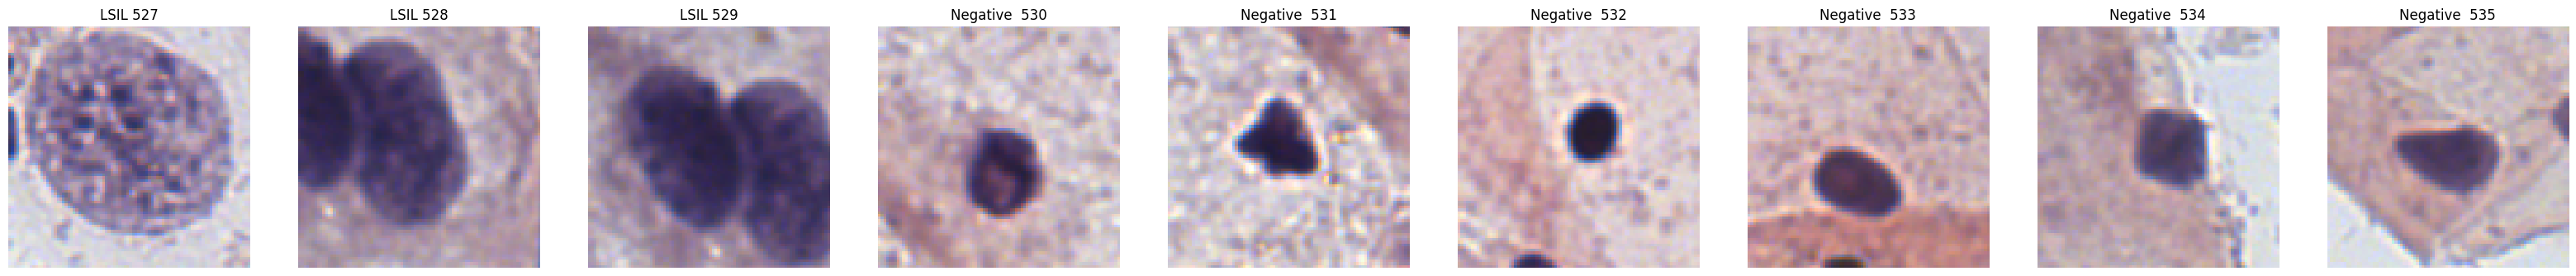

In [6]:
directory_path = '../../data/base_recortada/'
images = listar_imagens(directory_path)
exibir_imagens(images)

### Segmentação com Grabcut

In [7]:
def remover_fundo_com_grabcut_recortado(imagem):
    mascara = np.zeros(imagem.shape[:2], np.uint8)
    backgroundModel = np.zeros((1, 65), np.float64)
    foregroundModel = np.zeros((1, 65), np.float64)
    altura, largura = imagem.shape[:2]
    
    x1 = 0
    y1 = 0
    x2 = largura - 1
    y2 = altura - 1
        
    rectangle = (x1, y1, x2 - x1, y2 - y1)
    
    cv2.grabCut(imagem, mascara, rectangle,  
            backgroundModel, foregroundModel,
            3, cv2.GC_INIT_WITH_RECT)
    
    mascara_objeto = np.where((mascara == 2) | (mascara == 0), 0, 1).astype('uint8')
    
    imagem_sem_fundo = imagem * mascara_objeto[:, :, np.newaxis]
    
    img_recortada = imagem_sem_fundo[y1:y2, x1:x2]
    
    imagem_gray = cv2.cvtColor(img_recortada, cv2.COLOR_BGR2GRAY)
    
    _, mascara = cv2.threshold(imagem_gray, 10, 255, cv2.THRESH_BINARY)
    
    img_original_recortada = imagem[y1:y2, x1:x2]
    
    return img_recortada, mascara, img_original_recortada

In [7]:
def plot(resultados):
  num_cols = 3
  num_images = len(resultados)
  num_rows = (num_images + num_cols - 1) // num_cols 

  fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 4 * num_rows))

  for i, img in enumerate(resultados):
      row = i // num_cols
      col = i % num_cols
      img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      axes[row, col].imshow(img_rgb)
      axes[row, col].axis('off') 

  for j in range(num_images, num_rows * num_cols):
      fig.delaxes(axes.flat[j])

  plt.tight_layout()
  plt.show()

In [ ]:
imagens_path = listar_imagens("../../data/base_recortada/")
lista_resultado = []

for path_img in imagens_path:
  imagem = cv2.imread(path_img)
  img_recortada, mask, img_original_recortada = remover_fundo_com_grabcut_recortado(imagem=imagem)
  lista_resultado.append(img_recortada)
  lista_resultado.append(mask)
  lista_resultado.append(img_original_recortada)
  


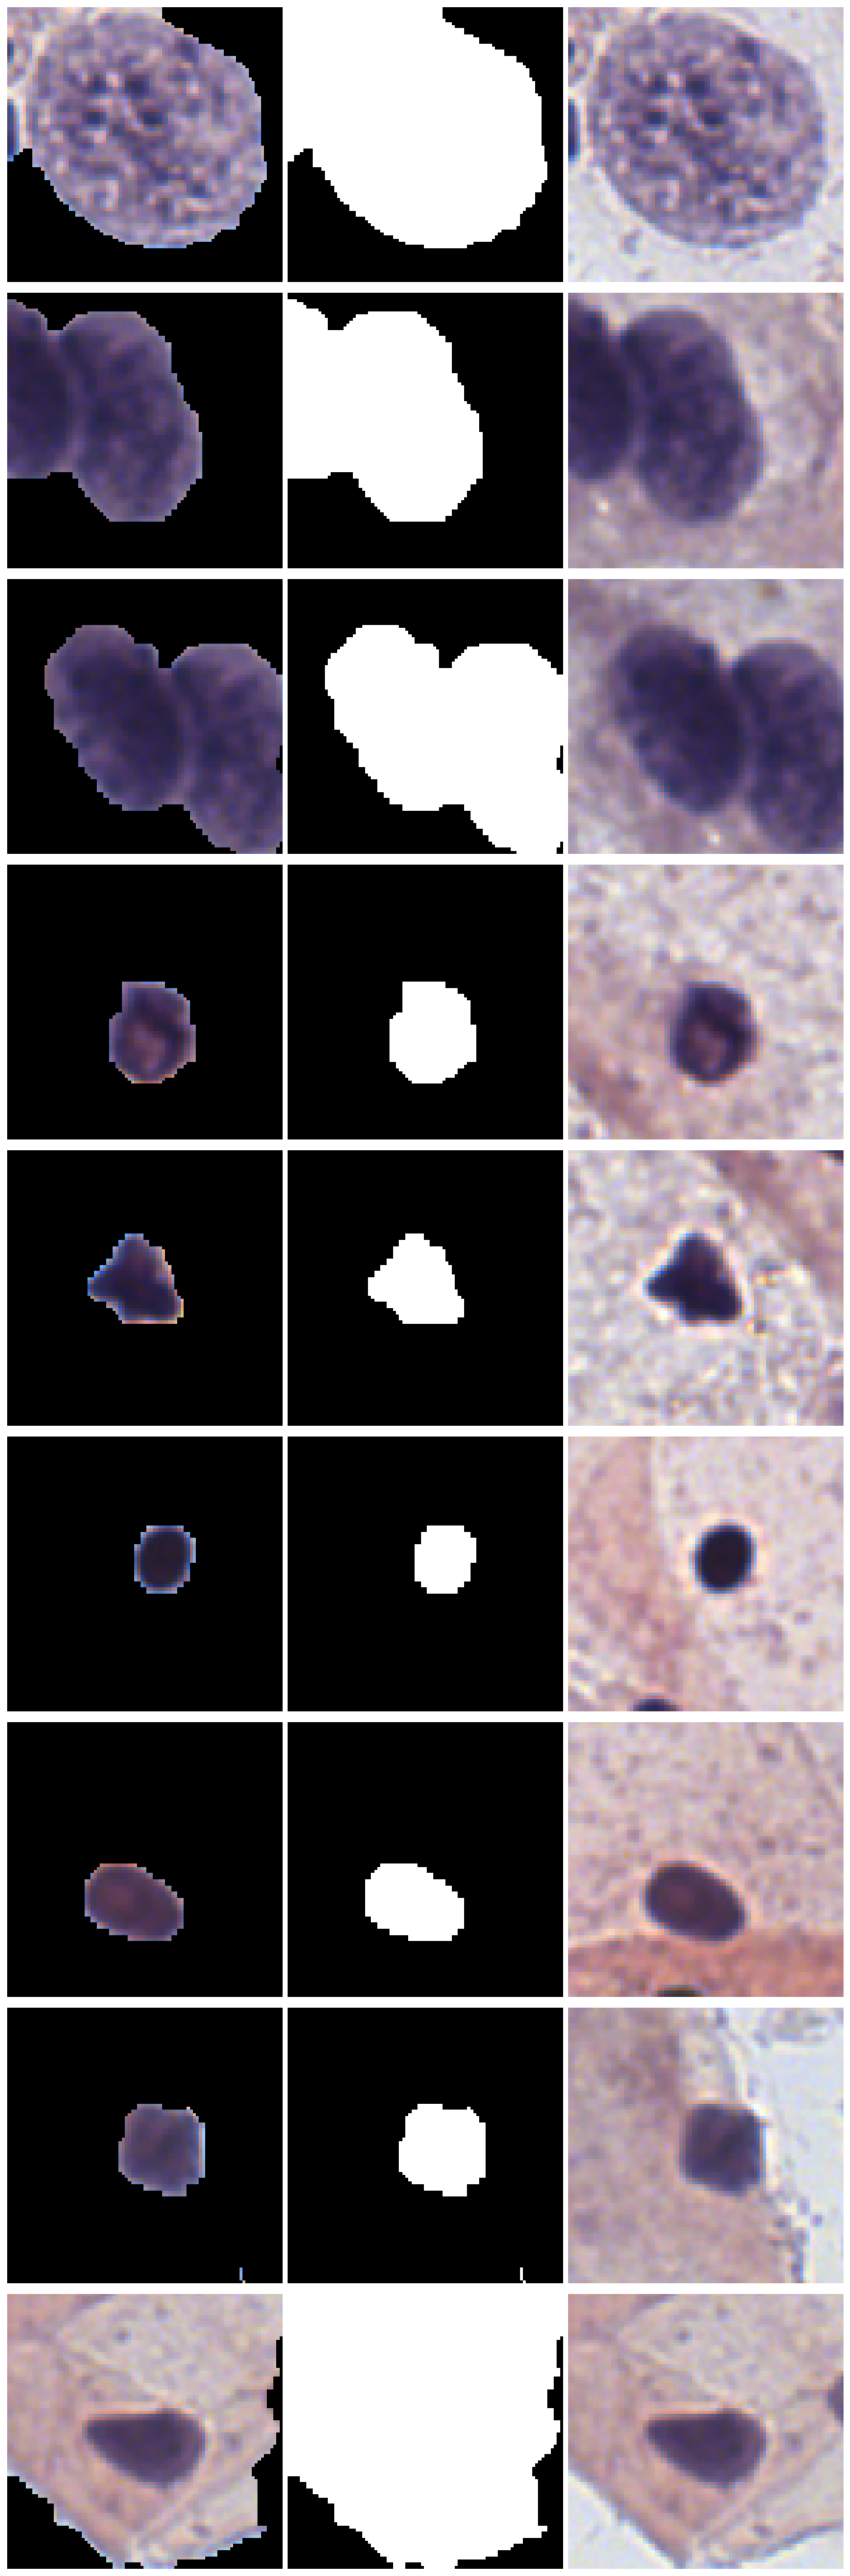

In [10]:
plot(lista_resultado)

### Definir Patches da areas de interesse

In [57]:
len(lista_resultado)

27

In [58]:
dict_img = {
  "img_com_mascara" : None,
  "mask" : None,
  "img_original": None,
}

array_dict_img = []

for item in range(0, 26, 3):
   dict_img["img_com_mascara"] = cv2.cvtColor(lista_resultado[item], cv2.COLOR_BGR2RGB)
   dict_img["mask"] = cv2.cvtColor(lista_resultado[item+1], cv2.COLOR_BGR2RGB)
   dict_img["img_original"] = cv2.cvtColor(lista_resultado[item+2], cv2.COLOR_BGR2RGB)
   array_dict_img.append(dict_img.copy())

In [59]:
len(array_dict_img)

9

(224, 224, 3)


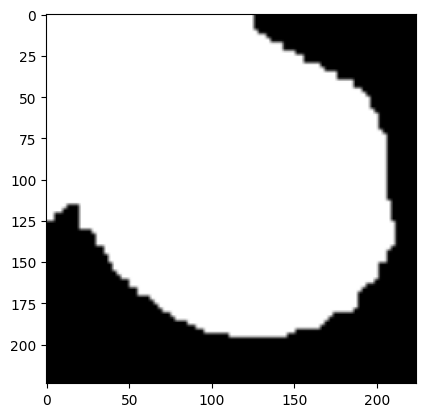

(224, 224, 3)


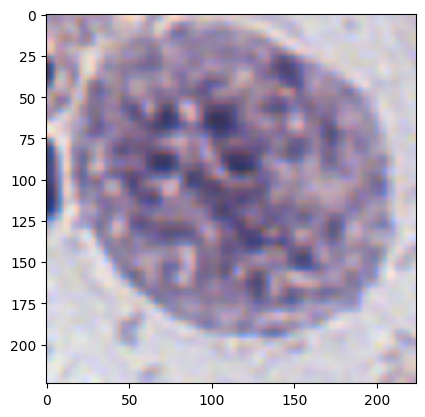

In [247]:
mask_test = array_dict_img[0]["mask"]
mask_test = cv2.resize(mask_test, (224, 224))
imagem_original = array_dict_img[0]["img_original"]
imagem_original = cv2.resize(imagem_original, (224, 224))

print(mask_test.shape)
plt.imshow(mask_test)
plt.show()
print(imagem_original.shape)
plt.imshow(imagem_original)
plt.show()

In [248]:
centers = []
altura, largura, _ = mask_test.shape

for i in range(altura):  
    for j in range(largura):
        pixel = mask_test[i, j]
        
        if len(pixel.shape) == 0:
            if pixel == 255:  
                  centers.append((i, j))
        else:  
            if np.array_equal(pixel, [255, 255, 255]): 
                  centers.append((i, j))

In [249]:
qtd_patches = int((224/16) * (224/16))
qtd_patches

196

In [250]:
len(centers)

32296

In [251]:
random.shuffle(centers)

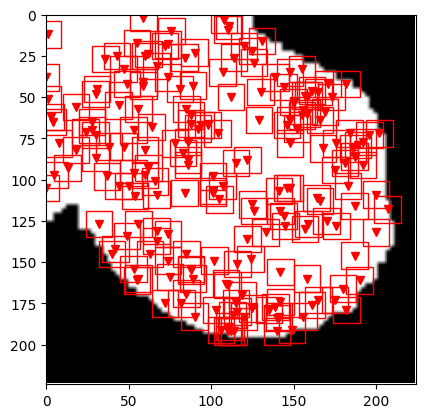

In [252]:
visualize_patch_centers(mask_test, centers[0:195], (16, 16))

### Algoritmo final da Extração de Patch por Mask

Algoritmo de patchs padrão

In [12]:
def generate_patch_centers(image_height, image_width, patch_size):
  
  stride = patch_size  
  
  num_patches_h = image_height // stride
  num_patches_w = image_width // stride
  
  centers_h = []
  centers_w = []
  
  for i in range(num_patches_h):
    centers_h.append((i * stride + stride // 2))
  
  for j in range(num_patches_w):
    centers_w.append((j * stride + stride // 2))
  
  centers = []

  for h in centers_h:
    for w in centers_w:
      centers.append((h,w))
  
  return centers

Funcao para verificar se a mascara veio defeituosa

In [9]:
def is_image_black_percentage(image, threshold=0.9):
    total_pixels = image.size
    
    if image.ndim == 2:
        black_pixels = np.sum(image == 0)
    elif image.ndim == 3: 
        black_pixels = np.sum(np.all(image == 0, axis=-1))

    black_percentage = black_pixels / total_pixels
    return black_percentage >= threshold

codigo que verifica centros validos

In [10]:
def validar_centros(centros, patch_size, tamanho_img=(224,224)):
    offset = patch_size // 2
    centros_validos = []
  
    for (x, y) in centros:
      if (x - offset >= 0 and x + offset - 1 < tamanho_img[0]) and (y - offset >= 0 and y + offset - 1 < tamanho_img[1]):
          centros_validos.append((x, y))
        
    return centros_validos


Remoção de Patches por segmentacao

In [5]:
def grabcutextractcenters(path_img, tamanho_img=(224, 224), stride=16):
  
  
  qtd_patches = int((tamanho_img[0]/stride) * (tamanho_img[0]/stride))
  
  print(f"Quantidade de patches da imagem: {qtd_patches}")
  
  imagem = cv2.imread(path_img)
  
  imagem = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)
  
  
  img_recortada, mask, img_original_recortada = remover_fundo_com_grabcut_recortado(imagem=imagem)
  
  if is_image_black_percentage(mask):
    
    altura, largura, _ = imagem.shape
    
    centers_merge = generate_patch_centers(altura, largura, stride)
    
    return centers_merge
  else:
    mask = cv2.resize(mask, tamanho_img)
    
    centers_randomicos = []
    centers_randomicos_validos = []
    centers_stride = []
    centers_stride_validos = []
    centers_merge = []
    altura, largura = mask.shape

    for i in range(altura):  
        for j in range(largura):
            pixel = mask[i, j]
            
            if len(pixel.shape) == 0:
                if pixel == 255:  
                      centers_randomicos.append((i, j))
            else:  
                if np.array_equal(pixel, [255, 255, 255]): 
                      centers_randomicos.append((i, j))
            
            
    centers_randomicos_validos = validar_centros(centros=centers_randomicos, patch_size=stride)
     
    
    
    for i in range(0, altura, stride):
          for j in range(0, largura, stride):
              pixel = mask[i, j]
              
              if len(pixel.shape) == 0: 
                  if pixel == 255:  
                      centers_stride.append((i, j))
              else:  
                  if np.array_equal(pixel, [255, 255, 255]):
                      centers_stride.append((i, j))
                      
    
    centers_stride_validos = validar_centros(centros=centers_stride, patch_size=stride)
                      
    
    quantidade_patches_stride = len(centers_stride_validos)
    
    if quantidade_patches_stride < qtd_patches:
      diferentes_lista1 = set(centers_randomicos_validos) - set(centers_stride_validos)
      diferentes_lista2 = set(centers_stride_validos) - set(centers_randomicos_validos)

      resultado = list(diferentes_lista1) + list(diferentes_lista2)
      
      random.shuffle(resultado)
      qtd_faltante_patches = qtd_patches - quantidade_patches_stride
      
      centers_merge = centers_stride_validos.copy()
      centers_merge.extend(resultado[0:qtd_faltante_patches])
    elif quantidade_patches_stride == qtd_patches:
      centers_merge = centers_stride_validos.copy()
      
      
      
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(img_recortada)
    axes[0].set_title('Imagem Recortada')
    axes[0].axis('off')  

    axes[1].imshow(mask, cmap='gray')
    axes[1].set_title('Máscara')
    axes[1].axis('off')

    axes[2].imshow(img_original_recortada)
    axes[2].set_title('Imagem Original Recortada')
    axes[2].axis('off') 
    
    return centers_merge

### Testando segmetação errada

In [23]:
imagem_preta = np.zeros((224, 224), dtype=np.uint8)

cv2.imwrite('imagem_preta.png', imagem_preta)

True

Quantidade de patches da imagem: 196
196


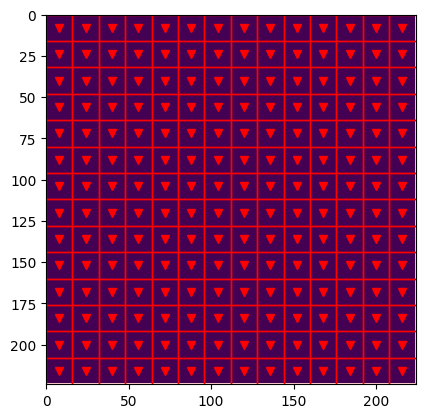

In [24]:
centers_final = grabcutextractcenters("imagem_preta.png")

print(len(centers_final))

visualize_patch_centers(imagem_preta, centers_final, (16, 16))

### Fazendo Metodo com Stride e Randomico

Quantidade de patches da imagem: 196
196


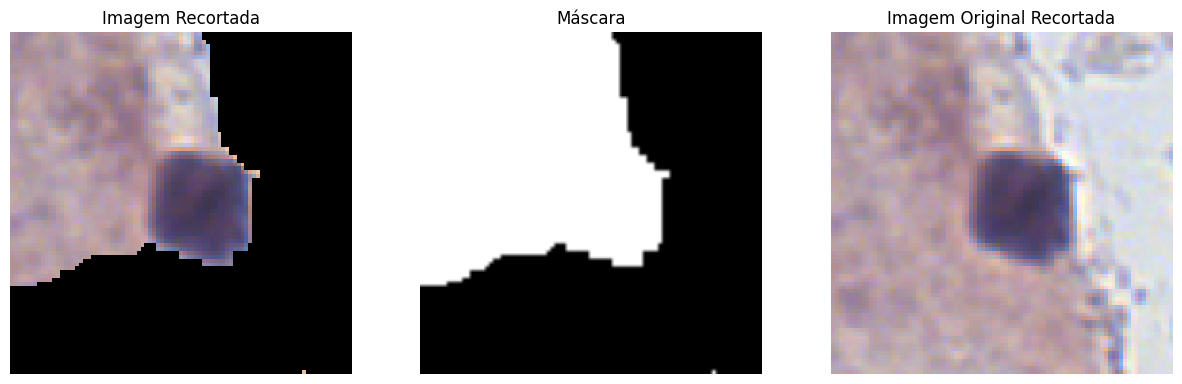

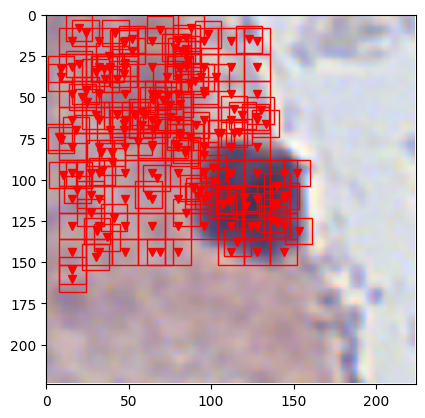

In [13]:
path_img = "../../data/base_recortada/Negative for intraepithelial lesion/534.png"
im = cv2.imread(path_img)
ir = cv2.resize(im, (224, 224))
ir = cv2.cvtColor(ir, cv2.COLOR_BGR2RGB)

centers_final = grabcutextractcenters(path_img)

print(len(centers_final))

visualize_patch_centers(ir, centers_final, (16, 16))

Quantidade de patches da imagem: 196
196


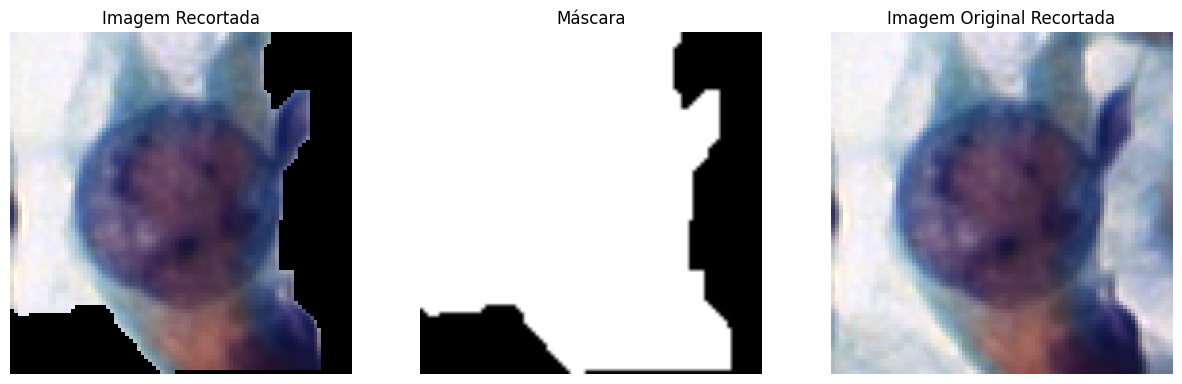

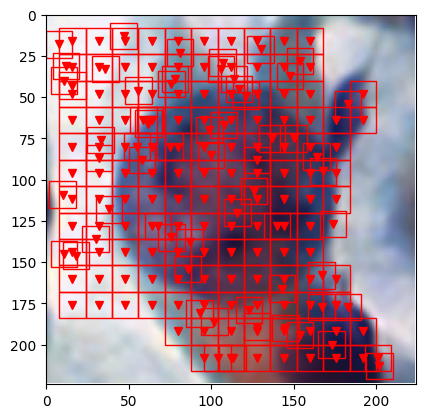

In [14]:
path_img = "../../data/base_recortada/LSIL/10060.png"
im = cv2.imread(path_img)
ir = cv2.resize(im, (224, 224))
ir = cv2.cvtColor(ir, cv2.COLOR_BGR2RGB)

centers_final = grabcutextractcenters(path_img)

print(len(centers_final))

visualize_patch_centers(ir, centers_final, (16, 16))

Quantidade de patches da imagem: 196
[(16, 16), (16, 32), (16, 48), (16, 64), (16, 80), (16, 96), (16, 112), (16, 128), (16, 144), (16, 160), (16, 176), (32, 16), (32, 32), (32, 48), (32, 64), (32, 80), (32, 96), (32, 112), (32, 128), (32, 144), (32, 160), (32, 176), (48, 16), (48, 32), (48, 48), (48, 64), (48, 80), (48, 96), (48, 112), (48, 128), (48, 144), (64, 16), (64, 32), (64, 48), (64, 64), (64, 80), (64, 96), (64, 112), (80, 16), (80, 32), (80, 48), (80, 64), (80, 80), (80, 96), (80, 112), (80, 128), (96, 16), (96, 32), (96, 48), (96, 64), (96, 80), (96, 96), (96, 112), (96, 128), (96, 144), (112, 16), (112, 32), (112, 48), (112, 64), (112, 80), (112, 96), (112, 112), (112, 128), (112, 144), (128, 32), (128, 48), (128, 64), (128, 80), (128, 96), (128, 112), (128, 128), (128, 144), (144, 80), (144, 96), (144, 112), (144, 128), (144, 144), (110, 72), (25, 183), (134, 96), (108, 130), (88, 57), (61, 41), (21, 134), (107, 115), (80, 69), (101, 15), (122, 42), (17, 146), (126, 89), 

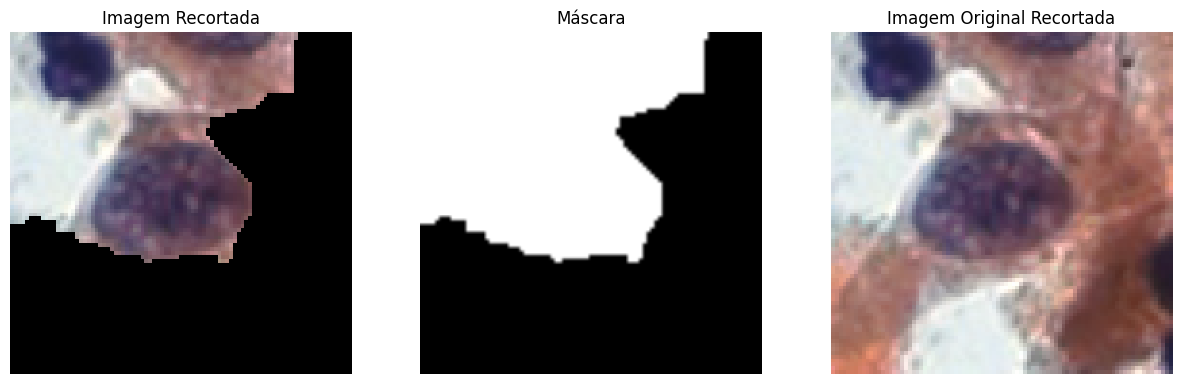

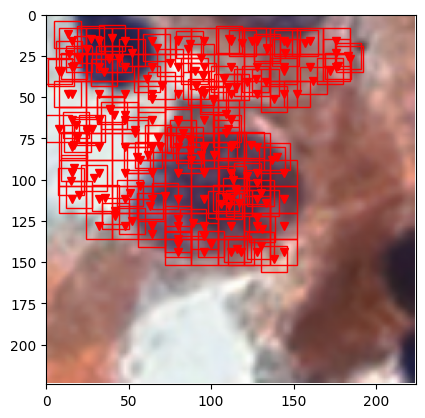

In [21]:
path_img = "../../data/base_recortada/ASC-H/10.png"
im = cv2.imread(path_img)
ir = cv2.resize(im, (224, 224))
ir = cv2.cvtColor(ir, cv2.COLOR_BGR2RGB)

centers_final = grabcutextractcenters(path_img, stride=16)

print(centers_final)
print(len(centers_final))

visualize_patch_centers(ir, centers_final, (16, 16))

In [45]:
def visualize_patch_centers(image, centers, patch_size, ax):
    image_np = np.array(image)
    
    if image_np.max() > 1:
        image_np = image_np / 255.0
    
    ax.imshow(image_np)
    
    patch_height, patch_width = patch_size
    
    for (h, w) in centers:
        rect = patches.Rectangle(
            (w - patch_width // 2, h - patch_height // 2), 
            patch_width, patch_height,
            linewidth=1, edgecolor='red', facecolor='none'
        )
        ax.add_patch(rect)
        ax.plot(w, h, marker='v', color='r')
    
    ax.set_xlim([0, image_np.shape[1]])
    ax.set_ylim([image_np.shape[0], 0])
    ax.set_title("Centros dos Patches")
    ax.axis('off')


def grabcutextractcenters_modificado(path_img, tamanho_img=(224, 224), stride=16):
    qtd_patches = int((tamanho_img[0] / stride) * (tamanho_img[0] / stride))
    print(f"Quantidade de patches da imagem: {qtd_patches}")
    
    imagem = cv2.imread(path_img)
    imagem = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)
    
    img_recortada, mask, img_original_recortada = remover_fundo_com_grabcut_recortado(imagem=imagem)
    
    if is_image_black_percentage(mask):
        altura, largura, _ = imagem.shape
        centers_merge = generate_patch_centers(altura, largura, stride)
    else:
        mask = cv2.resize(mask, tamanho_img)
        
        centers_randomicos = []
        centers_randomicos_validos = []
        centers_stride = []
        centers_stride_validos = []
        centers_merge = []
        altura, largura = mask.shape

        for i in range(altura):  
            for j in range(largura):
                pixel = mask[i, j]
                if len(pixel.shape) == 0:
                    if pixel == 255:  
                        centers_randomicos.append((i, j))
                else:  
                    if np.array_equal(pixel, [255, 255, 255]): 
                        centers_randomicos.append((i, j))
        
        centers_randomicos_validos = validar_centros(centros=centers_randomicos, patch_size=stride)
        
        for i in range(0, altura, stride):
            for j in range(0, largura, stride):
                pixel = mask[i, j]
                if len(pixel.shape) == 0: 
                    if pixel == 255:  
                        centers_stride.append((i, j))
                else:  
                    if np.array_equal(pixel, [255, 255, 255]):
                        centers_stride.append((i, j))
        
        centers_stride_validos = validar_centros(centros=centers_stride, patch_size=stride)
        
        quantidade_patches_stride = len(centers_stride_validos)
        
        if quantidade_patches_stride < qtd_patches:
            diferentes_lista1 = set(centers_randomicos_validos) - set(centers_stride_validos)
            diferentes_lista2 = set(centers_stride_validos) - set(centers_randomicos_validos)

            resultado = list(diferentes_lista1) + list(diferentes_lista2)
            random.shuffle(resultado)
            qtd_faltante_patches = qtd_patches - quantidade_patches_stride
            
            centers_merge = centers_stride_validos.copy()
            centers_merge.extend(resultado[0:qtd_faltante_patches])
        elif quantidade_patches_stride == qtd_patches:
            centers_merge = centers_stride_validos.copy()
    
    # Visualização das imagens com a quarta coluna para os centros dos patches
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    axes[0].imshow(img_original_recortada)
    axes[0].set_title('Imagem Original Recortada')
    axes[0].axis('off')
    
    axes[1].imshow(img_recortada)
    axes[1].set_title('Imagem Recortada')
    axes[1].axis('off')  

    axes[2].imshow(mask, cmap='gray')
    axes[2].set_title('Máscara')
    axes[2].axis('off')

    
    # Exibe os centros dos patches na quarta coluna
    resized_img = cv2.resize(imagem, tamanho_img)
    visualize_patch_centers(resized_img, centers_merge, (stride, stride), axes[3])

    plt.show()
    
    return centers_merge


Quantidade de patches da imagem: 196


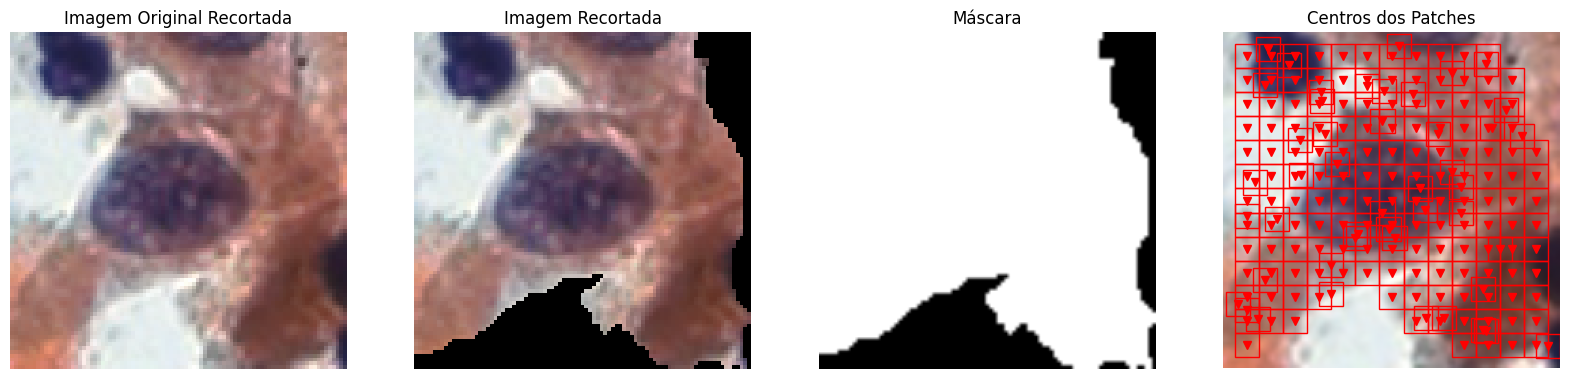

In [53]:
path_img = "../../data/base_recortada/ASC-H/10.png"
im = cv2.imread(path_img)
ir = cv2.resize(im, (224, 224))
ir = cv2.cvtColor(ir, cv2.COLOR_BGR2RGB)

centers_final = grabcutextractcenters_modificado(path_img, stride=16)

### Geração dos Patchs pré-treinados

In [4]:
import os
from torchvision.datasets import ImageFolder

class CustomImageFolder(ImageFolder):
    def __getitem__(self, index):
        img, target = super().__getitem__(index)

        path = self.imgs[index][0]

        image_name = os.path.basename(path)

        return img, target, image_name 

d:\AREA_DE_TRABALHO\Faculdade_8_Periodo\TCC\VIT-cric\vit-dynamic-patches\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
def visualize_patch_centers(image, centers, patch_size):
    fig, ax = plt.subplots(1)
    
    image_np = np.array(image)
    
    if image_np.max() > 1:
        image_np = image_np / 255.0
    
    ax.imshow(image_np)
    
    patch_height, patch_width = patch_size
    
    for (h, w) in centers:
        rect = patches.Rectangle(
            (w - patch_width // 2, h - patch_height // 2), 
            patch_width, patch_height,
            linewidth=1, edgecolor='red', facecolor='none'
        )
        ax.add_patch(rect)
        plt.plot(w, h, marker='v', color='r')
    
    ax.set_xlim([0, image_np.shape[1]])
    ax.set_ylim([image_np.shape[0], 0])
    
    plt.show()

In [6]:

def generate_patch_centers(image_height, image_width, patch_size):
  
  stride = patch_size  
  
  num_patches_h = image_height // stride
  num_patches_w = image_width // stride
  
  centers_h = []
  centers_w = []
  
  for i in range(num_patches_h):
    centers_h.append((i * stride + stride // 2))
  
  for j in range(num_patches_w):
    centers_w.append((j * stride + stride // 2))
  
  centers = []

  for h in centers_h:
    for w in centers_w:
      centers.append((h,w))
  
  return centers



def remover_fundo_com_grabcut_recortado(imagem):
    mascara = np.zeros(imagem.shape[:2], np.uint8)
    backgroundModel = np.zeros((1, 65), np.float64)
    foregroundModel = np.zeros((1, 65), np.float64)
    altura, largura = imagem.shape[:2]
    
    x1 = 0
    y1 = 0
    x2 = largura - 1
    y2 = altura - 1
        
    rectangle = (x1, y1, x2 - x1, y2 - y1)
    
    cv2.grabCut(imagem, mascara, rectangle,  
            backgroundModel, foregroundModel,
            3, cv2.GC_INIT_WITH_RECT)
    
    mascara_objeto = np.where((mascara == 2) | (mascara == 0), 0, 1).astype('uint8')
    
    imagem_sem_fundo = imagem * mascara_objeto[:, :, np.newaxis]
    
    img_recortada = imagem_sem_fundo[y1:y2, x1:x2]
    
    imagem_gray = cv2.cvtColor(img_recortada, cv2.COLOR_BGR2GRAY)
    
    _, mascara = cv2.threshold(imagem_gray, 10, 255, cv2.THRESH_BINARY)
    
    img_original_recortada = imagem[y1:y2, x1:x2]
    
    return img_recortada, mascara, img_original_recortada












def is_image_black_percentage(image, threshold=0.9):
    total_pixels = image.size
    
    if image.ndim == 2:
        black_pixels = np.sum(image == 0)
    elif image.ndim == 3: 
        black_pixels = np.sum(np.all(image == 0, axis=-1))

    black_percentage = black_pixels / total_pixels
    return black_percentage >= threshold


def validar_centros(centros, patch_size, tamanho_img=(224,224)):
    offset = patch_size // 2
    centros_validos = []
  
    for (x, y) in centros:
      if (x - offset >= 0 and x + offset - 1 < tamanho_img[0]) and (y - offset >= 0 and y + offset - 1 < tamanho_img[1]):
          centros_validos.append((x, y))
        
    return centros_validos







def grabcutextractcenters(imagem_tensor, tamanho_img=(224, 224), stride=16):
  
  
  
  imagem = imagem_tensor.permute(1, 2, 0).cpu().numpy()
    
    
  print(f"Shape da imagem {imagem.shape}")
  print(f"Type da imagem {type(imagem)}")
  
  qtd_patches = int((tamanho_img[0]/stride) * (tamanho_img[0]/stride))
  
  if imagem.max() <= 1:
    print("ZZZZZZZZZZZZZZZZZZ")
    imagem = (imagem * 255).astype(np.uint8) 
    
    
  imagem = cv2.cvtColor(imagem, cv2.COLOR_RGB2BGR)
  
  
  _ , mask, _ = remover_fundo_com_grabcut_recortado(imagem=imagem)
  
  if is_image_black_percentage(mask):
    
    altura, largura, _ = imagem.shape
    
    centers_merge = generate_patch_centers(altura, largura, stride)
    
    return centers_merge
  else:
    mask = cv2.resize(mask, tamanho_img)
    
    centers_randomicos = []
    centers_randomicos_validos = []
    centers_stride = []
    centers_stride_validos = []
    centers_merge = []
    altura, largura = mask.shape

    for i in range(altura):  
        for j in range(largura):
            pixel = mask[i, j]
            
            if len(pixel.shape) == 0:
                if pixel == 255:  
                      centers_randomicos.append((i, j))
            else:  
                if np.array_equal(pixel, [255, 255, 255]): 
                      centers_randomicos.append((i, j))
            
            
    centers_randomicos_validos = validar_centros(centros=centers_randomicos, patch_size=stride)
     
    
    
    for i in range(0, altura, stride):
          for j in range(0, largura, stride):
              pixel = mask[i, j]
              
              if len(pixel.shape) == 0: 
                  if pixel == 255:  
                      centers_stride.append((i, j))
              else:  
                  if np.array_equal(pixel, [255, 255, 255]):
                      centers_stride.append((i, j))
                      
    
    centers_stride_validos = validar_centros(centros=centers_stride, patch_size=stride)
                      
    
    quantidade_patches_stride = len(centers_stride_validos)
    
    if quantidade_patches_stride < qtd_patches:
      diferentes_lista1 = set(centers_randomicos_validos) - set(centers_stride_validos)
      diferentes_lista2 = set(centers_stride_validos) - set(centers_randomicos_validos)

      resultado = list(diferentes_lista1) + list(diferentes_lista2)
      
      random.shuffle(resultado)
      qtd_faltante_patches = qtd_patches - quantidade_patches_stride
      
      centers_merge = centers_stride_validos.copy()
      centers_merge.extend(resultado[0:qtd_faltante_patches])
    elif quantidade_patches_stride == qtd_patches:
      centers_merge = centers_stride_validos.copy()
      
      
      
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    img_original_recortada = cv2.resize(imagem, tamanho_img)
    
    axes[0].imshow(mask, cmap='gray')
    axes[0].set_title('Máscara')
    axes[0].axis('off')

    axes[1].imshow(img_original_recortada)
    axes[1].set_title('Imagem Original Recortada')
    axes[1].axis('off') 
    
    return centers_merge

Shape da imagem (224, 224, 3)
Type da imagem <class 'numpy.ndarray'>
ZZZZZZZZZZZZZZZZZZ
O Nome da imagem é: 10.png
49
[(32, 32), (32, 64), (32, 96), (32, 128), (32, 160), (64, 32), (64, 64), (64, 96), (64, 128), (64, 160), (64, 192), (96, 32), (96, 64), (96, 96), (96, 128), (96, 160), (96, 192), (128, 32), (128, 64), (128, 96), (128, 128), (128, 160), (128, 192), (160, 32), (160, 64), (160, 96), (160, 128), (160, 160), (160, 192), (192, 32), (192, 160), (192, 192), (162, 28), (72, 116), (66, 77), (53, 159), (160, 195), (130, 39), (160, 20), (101, 183), (32, 179), (71, 21), (144, 141), (137, 114), (64, 164), (82, 28), (130, 38), (44, 153), (148, 153)]


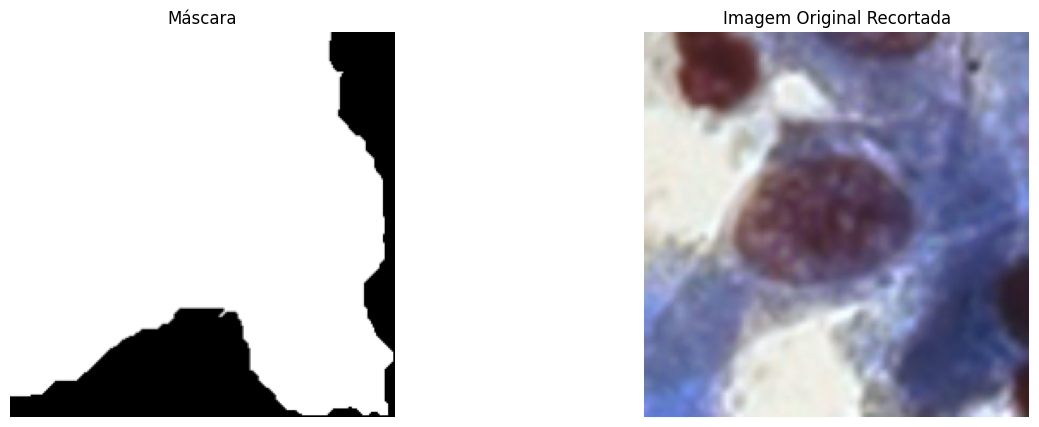

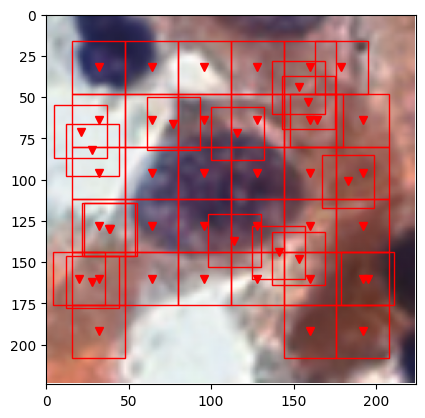

Shape da imagem (224, 224, 3)
Type da imagem <class 'numpy.ndarray'>
ZZZZZZZZZZZZZZZZZZ
O Nome da imagem é: 10000.png
49
[(32, 32), (32, 64), (32, 96), (32, 128), (32, 160), (32, 192), (64, 32), (64, 64), (64, 96), (64, 128), (64, 160), (64, 192), (96, 32), (96, 64), (96, 96), (96, 128), (96, 160), (96, 192), (128, 64), (128, 96), (128, 128), (128, 160), (128, 192), (142, 142), (27, 129), (42, 191), (100, 133), (125, 74), (78, 64), (78, 30), (91, 162), (29, 208), (19, 149), (99, 19), (57, 132), (110, 119), (46, 133), (120, 67), (29, 147), (42, 79), (33, 137), (50, 30), (54, 95), (131, 122), (131, 98), (60, 57), (94, 165), (61, 181), (111, 70)]


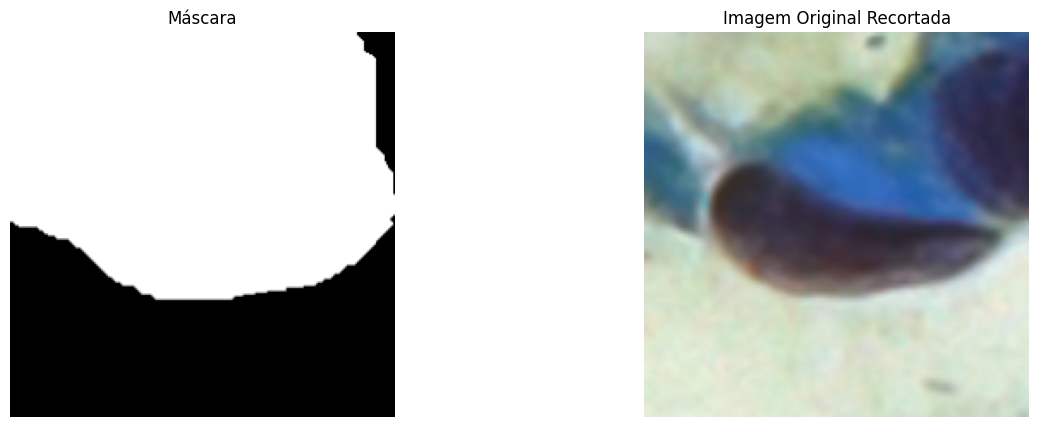

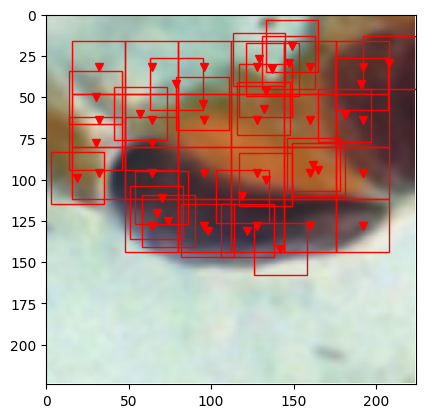

Shape da imagem (224, 224, 3)
Type da imagem <class 'numpy.ndarray'>
ZZZZZZZZZZZZZZZZZZ
O Nome da imagem é: 10001.png
49
[(32, 32), (32, 64), (32, 96), (32, 128), (32, 160), (32, 192), (64, 32), (64, 64), (64, 96), (64, 128), (64, 160), (64, 192), (96, 32), (96, 64), (96, 96), (96, 128), (96, 160), (96, 192), (128, 32), (128, 64), (128, 96), (128, 128), (128, 160), (160, 32), (160, 64), (160, 96), (160, 128), (160, 160), (192, 32), (192, 64), (197, 55), (108, 161), (60, 170), (64, 45), (31, 177), (143, 87), (134, 141), (143, 55), (61, 146), (19, 44), (202, 69), (124, 58), (180, 28), (46, 47), (151, 139), (69, 156), (20, 187), (190, 43), (137, 45)]


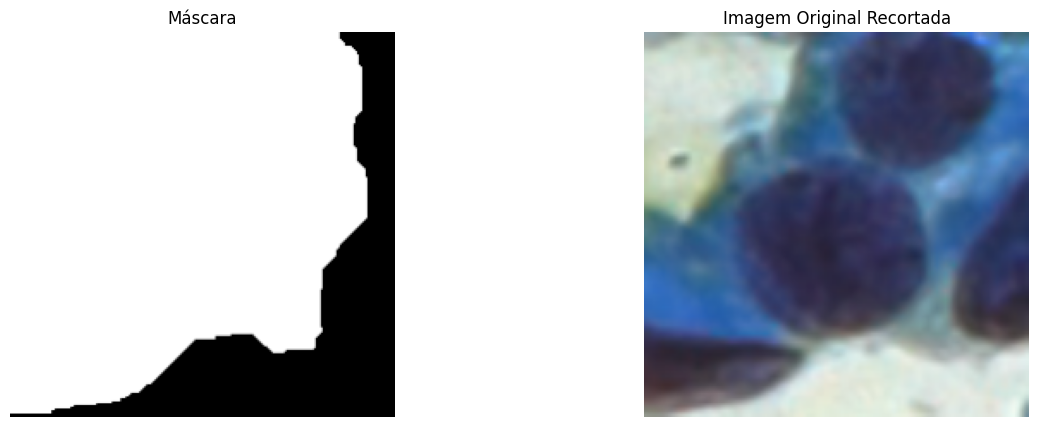

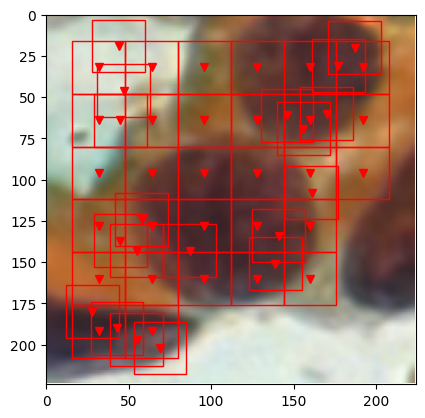

Shape da imagem (224, 224, 3)
Type da imagem <class 'numpy.ndarray'>
ZZZZZZZZZZZZZZZZZZ
O Nome da imagem é: 10002.png
49
[(32, 32), (32, 64), (32, 96), (32, 128), (32, 160), (32, 192), (64, 32), (64, 64), (64, 96), (64, 128), (64, 160), (64, 192), (96, 32), (96, 64), (96, 96), (96, 128), (96, 160), (96, 192), (128, 32), (128, 64), (128, 96), (128, 128), (128, 160), (128, 192), (160, 32), (160, 64), (160, 96), (160, 128), (160, 160), (67, 97), (125, 184), (94, 58), (21, 74), (111, 77), (100, 189), (172, 117), (150, 176), (97, 83), (128, 113), (88, 192), (137, 164), (26, 102), (92, 109), (156, 48), (103, 190), (59, 74), (70, 25), (51, 49), (148, 186)]


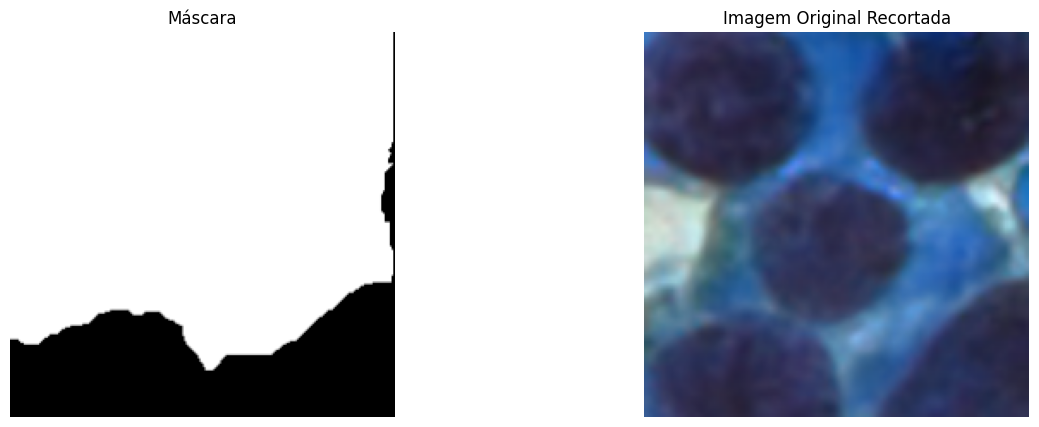

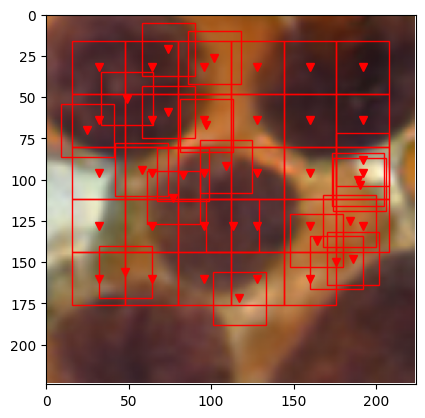

Shape da imagem (224, 224, 3)
Type da imagem <class 'numpy.ndarray'>
ZZZZZZZZZZZZZZZZZZ
O Nome da imagem é: 10003.png
49
[(32, 32), (32, 64), (32, 96), (32, 128), (64, 32), (64, 64), (64, 96), (64, 128), (96, 32), (96, 64), (96, 96), (96, 128), (96, 160), (96, 192), (128, 32), (128, 64), (128, 96), (128, 128), (128, 160), (128, 192), (160, 32), (160, 64), (160, 96), (160, 128), (160, 160), (160, 192), (192, 32), (192, 64), (192, 96), (37, 92), (125, 101), (125, 29), (148, 73), (202, 34), (197, 32), (109, 87), (34, 111), (50, 20), (144, 194), (179, 56), (77, 104), (102, 65), (114, 202), (156, 147), (85, 100), (41, 121), (81, 146), (122, 38), (174, 58)]


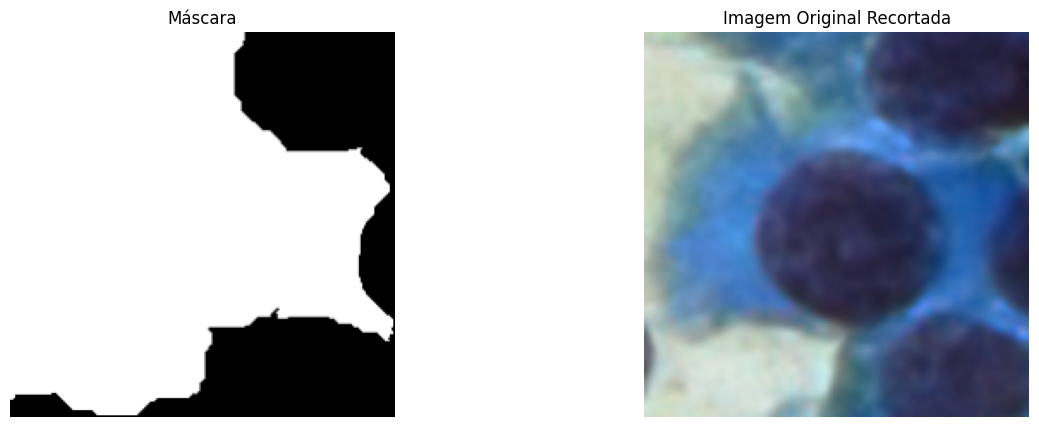

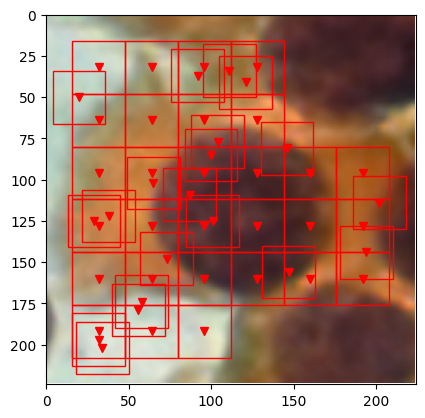

In [ ]:
from torchvision.transforms import v2
import pickle
import numpy as np

pickle_file = "../data/centros_pre_salvos/segmentacao_dicionario.pkl"

img_size = (224, 224)
batch_size = 32

transform = v2.Compose([
    v2.Resize(img_size),
    v2.ToTensor(),
])

# dataset = CustomImageFolder(root="../data/id_base_recortada/", transform=transform)
dataset = CustomImageFolder(root="../../data/base_recortada/", transform=transform)


# lista_centro_dict = []

centros_dict = {}

for img_idx in range(5):
    image, label, image_name = dataset[img_idx] 

    
    centers = grabcutextractcenters(image, stride=32)
    
    
    centros_dict[image_name] = centers
    
    
    im = Image.fromarray((image.permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8))
    
    imagem_rgb = im.convert('RGB')
    resized_image = imagem_rgb.resize((224, 224))
    print(f"O Nome da imagem é: {image_name}")
    print(len(centers))
    print(centers)
    visualize_patch_centers(resized_image, centers, (32, 32))
    
# Salvando o dicionário em um arquivo pickle
# with open(pickle_file, 'wb') as f:
#     pickle.dump(centros_dict, f)

# print(f"Centros dos patches salvos em {pickle_file}")

In [21]:
for k,v in centros_dict.items():
  print(f"Key: {k}, quantidade de Value: {len(v)}")

Key: 10.png, quantidade de Value: 196
Key: 10000.png, quantidade de Value: 196
Key: 10001.png, quantidade de Value: 196
Key: 10002.png, quantidade de Value: 196
Key: 10003.png, quantidade de Value: 196
